## TC 5033
### Text Classifier

Juan Antonio Chiñas Mata: A01794191 <br>
José Alejandro Cortés Pérez: A01795033 <br>
Moises Flores Ortíz: A01795489 <br>
Mardonio Manuel Román Ramírez: A01795265 <br>
Miriam Eunice Rosas Medellín: A01795550 <br><br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)
        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


## Import libraries and setup

In [1]:
# -- IMPORTANT --
# GOOGLE COLAB SETUP

# Install PyTorch, TorchVision, Torchaudio with CUDA 11.8 support
!pip install torch==2.0.1+cu118 \
    torchvision==0.15.2+cu118 \
    torchaudio==2.0.2+cu118 \
    -f https://download.pytorch.org/whl/torch_stable.html

# Install torchtext and torchdata
!pip install torchtext==0.15.2

# Install portalocker
!pip install portalocker>=2.0.0

# Install scikit-plot for confusion matrix plotting
!pip install scipy==1.11.0
!pip install scikit-plot

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
# The following libraries are required for running the given code
# Feel free to add any libraries you consider adequate to complete the assignment
import os
import gc
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
import portalocker

# These libraries are suggested for plotting the confusion matrix
# You may use others if preferred
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Set the location of the PyTorch cache directory to '/tmp/torch_cache'
os.environ['TORCH_HOME'] = '/tmp/torch_cache'

In [3]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Data Preparation

The **AG_NEWS** dataset will be used to train and test RNNs models for text classification. The AG_NEWS dataset is a dataset for news topic classification. It consists of news articles categorized into four main topics:

*   **World**: News related to global events, international politics, and global affairs
*   **Sports**: News about sports events, games, athletes, and sports-related stories
*   **Business**: Articles covering financial news, economic updates, business-related developments, and market trends
*   **Sci/Tech**: News focused on science and technology, including research updates, tech developments, and related discoveries


Each data entry in the dataset consists of a tuple containing a label representing the topic and the text of the news headline.

**Dataset summary:**
*   Number of Classes: 4
*   Data Format: The dataset entries are tuples, with each containing a label and the text
*   Size: 120,000 training samples and 7,600 test samples


**Classes**:
* 1 - World
* 2 - Sports
* 3 - Business
* 4 - Sci/Tech

#### Get the train and the test datasets and dataloaders

First, we have loaded the AG_NEWS dataset into train and test sets and indexing them so the Pytorch Dataloders can process as per the required format.

In [4]:
# Load the AG_NEWS dataset (training and test splits)
train_dataset, test_dataset = AG_NEWS()

# Convert the datasets to map-style format for easier indexing and compatibility with DataLoader
train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [5]:
# Print the first 5 samples from the training dataset
for i in range(5):
    print(train_dataset[i])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
(3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
(3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")
(3, 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')
(3, 'Oil prices soar to all-time record, posing new menace t

Then we defined a tokinizer that will split text into words, convert text to lowercase and split by spaces. Then we required a function that tokinize the data but using a yield to generate tokens one at a time, rather than storing them all in memory, making the process efficient for large datasets.

In [6]:
# Get the tokenizer
# Create a tokenizer object using basic English tokenization
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data):
    """
    Generator function to tokenize text data.

    Args:
        data (iterable): An iterable of samples, where each sample is a tuple
                         containing an ID and a text string (e.g., (label, text)).

    Yields:
        list: A list of tokens obtained by tokenizing the text string using the tokenizer.
    """
    for _, text in data:
        yield tokenizer(text)

We also have to build the vocabulary containing a mapping of each unique word in `train_dataset` to a unique integer index and setting `<unk>` which stands for "unknown." This token will represent any word not found in the vocabulary during training or inference. This vocabulary will allow us to convert words into numerical indices, making it easier to process text as input for the RNN model.

In [7]:
# Build the vocabulary from the tokenized training dataset
vocab = build_vocab_from_iterator(
    yield_tokens(train_dataset),
    specials=['<unk>']
)

# Set the unknown token ('<unk>') to have a default index of 0
vocab.set_default_index(vocab['<unk>'])

Let's test the tokenizer...

In [8]:
# Test the tokenizer
tokens = tokenizer('Welcome to TE3007')

# Convert the list of words into a list of tokens using the vocabulary
print(f"Let's convert this list of words: {tokens} into a list of tokens: {vocab(tokens)}")

Let's convert this list of words: ['welcome', 'to', 'te3007'] into a list of tokens: [3314, 4, 0]


Now, let's split the train set into train and validation sets. The train set will contain 90% of the original training data, ensuring that the remaining 10% is available for validation.

In [9]:
# Calculate the number of training and validation samples
NUM_TRAIN = int(len(train_dataset) * 0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [10]:
# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [11]:
# Print the sizes of the train, validation, and test datasets
print(f'Train dataset: {len(train_dataset)}, '
      f'Validation set: {len(val_dataset)}, '
      f'Test set: {len(test_dataset)}')

Train dataset: 108000, Validation set: 12000, Test set: 7600


Then we required a function that prepares the batch by tokenizing, padding/truncating sequences, and adjusting labels, making it compatible for processing by the model. The function will return a Pytorch tensor with these tokenized and padded sequences. Also, note that in here we are converting labels in this way:

Classes:
* 1 - World
* 2 - Sports
* 3 - Business
* 4 - Sci/Tech

We will convert them to:
* 0 - World
* 1 - Sports
* 2 - Business
* 3 - Sci/Tech

In [12]:
# Function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    """
    Collates a batch of data by tokenizing the text and preparing labels.

    Args:
        batch (list): A list of tuples, where each tuple contains a label and a text string.

    Returns:
        tuple: A tuple containing two tensors:
            - A tensor of tokenized and padded text sequences (shape: [batch_size, max_tokens])
            - A tensor of labels (shifted by 1 to be in the range 0-3)
    """
    # Get label and text
    y, x = list(zip(*batch))

    # Create a list with indices from the tokenizer
    x = [vocab(tokenizer(text)) for text in x]

    # Pad or truncate the tokenized sequences to ensure they are of length max_tokens
    x = [t + ([0] * (max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels by subtracting 1 to shift them to the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int64) - 1

Let's set the labels, max number of tokens for the batching and the batch size...

In [13]:
# List of labels for the dataset categories
labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Maximum number of tokens allowed per text sequence
max_tokens = 50

# Batch size for data loading
BATCH_SIZE = 256

Also, we need to convert the datasets into DataLoaders for Pytorch processing.  We use `DataLoader` to load data in batches and ensures that the data is efficiently processed during training and evaluation.

In [14]:
# Create DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    shuffle=True
)

# Create DataLoader for the validation dataset
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    shuffle=True
)

# Create DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch,
    shuffle=True
)

## Model Setup

We have designed the model RNN_model_1 to classify text data (AG_NEWS dataset in this case) by processing it with an RNN-based architecture and it gives the possibility to use 3 RNN types such as GRU, LSTM and baseline RNN. The model uses word embeddings to convert words into vector representations, applies an RNN to capture sequential patterns, and then classifies the final output using a fully connected layer, in this case, to the four classes that were defined previously.

#### Let us build our RNN model

In [15]:
class RNN_Model_1(nn.Module):
    """
    A neural network model using RNN (GRU, LSTM, or RNN) for text classification.

    Args:
        embed_size (int): The size of the embedding vectors.
        hidden (int): The number of hidden units in the RNN layer.
        layers (int): The number of layers in the RNN.
        num_classes (int): The number of output classes.
        rnn_type (str, optional): Type of RNN ('GRU', 'LSTM', 'RNN'). Default is 'GRU'.
        dropout_prob (float, optional): Probability of dropout. Default is 0.3.
    """

    def __init__(self, embed_size, hidden, layers, num_classes, rnn_type='GRU', dropout_prob=0.3):
        super().__init__()

        # Embedding layer to convert words into dense vectors
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_prob)

        # RNN layer selection based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=embed_size,
                              hidden_size=hidden,
                              num_layers=layers,
                              batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=embed_size,
                               hidden_size=hidden,
                               num_layers=layers,
                               batch_first=True)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size=embed_size,
                              hidden_size=hidden,
                              num_layers=layers,
                              batch_first=True)
        else:
            raise ValueError("Invalid rnn_type. Choose from 'GRU', 'LSTM', or 'RNN'.")

        # Fully connected output layer
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        """
        Forward pass for the RNN model.

        Args:
            x (tensor): Input tensor of shape (batch_size, sequence_length).

        Returns:
            tensor: Output tensor after passing through the network.
        """
        # Embed the input x
        embedded = self.embedding_layer(x)

        # RNN layer (we ignore the hidden state here for simplicity)
        output, _ = self.rnn(embedded)

        # Take the output from the last time step
        final_output = output[:, -1, :]

        # Pass through the fully connected layer
        return self.fc(final_output)

## Implementing Accuracy Function

Then we implemented thee function accuracy() that calculates the classification accuracy of the model over a given dataset. The function computes the accuracy of the model by evaluating its predictions over the provided data loader (e.g., train_loader, val_loader, or test_loader).
It processes each batch in the loader, predicts the class for each sample, and counts how many predictions are correct.
Finally, it returns the fraction of correct predictions out of the total number of samples.

In [16]:
def accuracy(model, loader):
    """
    Calculate the accuracy of the model on the given dataset.

    Args:
        model (nn.Module): The neural network model to evaluate.
        loader (DataLoader): The DataLoader for the dataset to evaluate on.

    Returns:
        float: The accuracy of the model as a fraction.
    """
    correct = 0
    total = 0

    # Disable gradient calculation for evaluation (inference mode)
    with torch.no_grad():
        for x, y in loader:
            # Move data to the specified device (GPU or CPU)
            x, y = x.to(device), y.to(device)

            # Get model predictions
            outputs = model(x)

            # Get the index of the maximum log-probability for classification
            _, predicted = torch.max(outputs, 1)

            # Update the count of correct predictions
            correct += (predicted == y).sum().item()

            # Update the total count of examples
            total += y.size(0)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    return correct / total

## Training Function

Furthermore, we created the training functions that loops over each epoch, computes the loss for each batch, and updates the model parameters. For each batch, it calculates the loss and backpropagates the error through the network, and after each epoch, the function calculates the model's performance on a validation dataset and prints the results.

In [17]:
def train(model, optimiser, train_loader, val_loader, epochs=100):
    """
    Train the model on the training dataset and evaluate on the validation dataset.

    Args:
        model (nn.Module): The neural network model to be trained.
        optimiser (torch.optim.Optimizer): The optimizer used for training the model.
        train_loader (DataLoader): The DataLoader for the training dataset.
        val_loader (DataLoader): The DataLoader for the validation dataset.
        epochs (int, optional): The number of epochs to train the model. Default is 100.
    """
    # Set the model to training mode (enables behaviors like dropout)
    model.train()

    # Define the loss function (Cross-Entropy Loss for classification)
    criterion = nn.CrossEntropyLoss()

    # Loop through each epoch
    for epoch in range(epochs):
        running_loss = 0.0

        # Loop through each batch in the training dataset
        for x, y in train_loader:
            # Move data to the specified device (GPU or CPU)
            x, y = x.to(device), y.to(device)

            # Forward pass: compute model predictions
            outputs = model(x)

            # Compute the loss between predictions and true labels
            loss = criterion(outputs, y)

            # Backward pass and optimization
            optimiser.zero_grad()  # Clear previous gradients
            loss.backward()  # Backpropagate the error
            optimiser.step()  # Update the model parameters

            # Track the running loss for the epoch
            running_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_loss = running_loss / len(train_loader)

        # Validate model performance after each epoch
        val_accuracy = accuracy(model, val_loader)

        # Ensure the model is back in training mode for the next epoch
        model.train()

        # Print the results for the current epoch
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Let's define hyperparameters. After varying the hyperparameters we set them according to the best performance of around 90% of accuracy:

In [18]:
# Model configuration parameters
RNN_TYPE = 'GRU'      # Choose from "GRU", "LSTM", or "RNN" (type of RNN)
EMBEDDING_SIZE = 128  # Dimension of word embeddings
NEURONS = 256         # Number of neurons in the RNN layer
LAYERS = 4            # Number of RNN layers
NUM_CLASSES = 4       # Number of output classes (for AG_NEWS dataset)
DROPOUT_PROB = 0.3    # Probability of dropout to prevent overfitting

In [19]:
# Training configuration
epochs = 10  # Number of epochs to train the model
lr = 0.001   # Learning rate for the optimizer

# Instantiate the model
rnn_model = RNN_Model_1(
    EMBEDDING_SIZE,  # Size of word embeddings
    NEURONS,         # Number of neurons in the RNN layer
    LAYERS,          # Number of RNN layers
    NUM_CLASSES,     # Number of output classes
    RNN_TYPE,        # Type of RNN ("GRU", "LSTM", or "RNN")
    DROPOUT_PROB     # Dropout probability to prevent overfitting
).to(device)  # Move the model to the specified device (CPU or GPU)

# Instantiate the optimizer
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)  # Adam optimizer with the specified learning rate

Now, let's train the model...

In [20]:
# Train the model with the specified parameters
train(
    rnn_model,                  # The RNN model to be trained
    optimiser=optimiser,        # The optimizer used for training
    train_loader=train_loader,  # DataLoader for the training dataset
    val_loader=val_loader,      # DataLoader for the validation dataset
    epochs=epochs               # Number of epochs to train the model
)

Epoch [1/10], Loss: 0.6333, Validation Accuracy: 0.8763
Epoch [2/10], Loss: 0.2823, Validation Accuracy: 0.8933
Epoch [3/10], Loss: 0.2067, Validation Accuracy: 0.9029
Epoch [4/10], Loss: 0.1527, Validation Accuracy: 0.9041
Epoch [5/10], Loss: 0.1149, Validation Accuracy: 0.9103
Epoch [6/10], Loss: 0.0833, Validation Accuracy: 0.9059
Epoch [7/10], Loss: 0.0617, Validation Accuracy: 0.9073
Epoch [8/10], Loss: 0.0474, Validation Accuracy: 0.9044
Epoch [9/10], Loss: 0.0366, Validation Accuracy: 0.9044
Epoch [10/10], Loss: 0.0285, Validation Accuracy: 0.9065


We obtain a similar accuracy between validation and tests set and the difference between both is less than 3% so we can conclude the model is performing without overfitting.

In [21]:
# Evaluate the model on the test set and print the accuracy
test_accuracy = accuracy(rnn_model, test_loader)  # Calculate accuracy on the test dataset
print(f'Test Accuracy: {test_accuracy:.4f}')  # Print the test accuracy rounded to four decimal places

Test Accuracy: 0.9062


## Text Sampling

 The function created is used for sampling a single text from a dataset and making a prediction using a trained model. Basically, a data loders is provided, typically from validation or test sets, then the text is predicted or in this case it is classified and finally it the text and class or label are returned.

In [23]:
def sample_text(model, loader):
    """
    Sample text from the test set and get the model's prediction.

    Args:
        model (nn.Module): The trained model to make predictions.
        loader (DataLoader): The DataLoader containing the test dataset.
    """
    # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model.eval()

    with torch.no_grad():  # Disable gradient calculation (save memory during inference)
        # Get a sample from the test loader (first batch)
        sample_data = next(iter(loader))  # Retrieve the first batch from the loader
        x, y = sample_data
        x, y = x.to(device), y.to(device)  # Move data to the specified device (CPU or GPU)

        # Get predictions from the model
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output value

        # Convert token indices to text for the sample
        sample_text = vocab.lookup_tokens(x[0].cpu().tolist())  # Convert token indices to words
        predicted_label = labels[predicted[0].item()]  # Get the predicted label

        # Display the sample text and its predicted label
        print(f"Sample Text: {' '.join(sample_text)}")
        print(f"Predicted Label: {predicted_label}")

Let's check some exaples where a text from the news are provided and the model successfully clasifies the text into the four classes.

In [24]:
# Call the sample_text function to evaluate a sample from the test dataset
sample_text(rnn_model, test_loader)  # Pass the trained model and the test DataLoader

Sample Text: <unk> la la , apple unveils new imac ( siliconvalley . com ) siliconvalley . com - attempting to capitalize on ipod mania , apple computer tuesday unveiled a fast new version of the imac that it all but touted as a smart accessory for the sexy music players .
Predicted Label: Sci/Tech


In [25]:
# Call the sample_text function to evaluate a sample from the test dataset
sample_text(rnn_model, test_loader)  # Pass the trained model and the test DataLoader

Sample Text: lowe #39 s forecast hammers stock home improvement retailer lowe #39 s cos . ( low . n quote , profile , research ) on monday reported a 15 percent rise in third-quarter profit , aided by its expansion to new york <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Predicted Label: Business


In [26]:
# Call the sample_text function to evaluate a sample from the test dataset
sample_text(rnn_model, test_loader)  # Pass the trained model and the test DataLoader

Sample Text: viduka brace helps boro to win after a spell without scoring , mark viduka grabbed two goals as middlesbrough beat manchester city 3-2 . boro went ahead when viduka took stewart <unk> pass , brought it <unk> under control and chipped it over onrushing city keeper david james . <unk>
Predicted Label: Sports


As can be seen, the model is correctly classifying the text into the appropriate categories, as the content of the news aligns with the topics of those categories.

## Confusion Matrix

A good metric for classification is the confusion matrix, in this case we created a function that plots the confusion matrix for the predicted and real values for the four news' categories.

In [44]:
def plot_confusion_matrix(model, loader):
    """
    Plot a confusion matrix for the given model and dataset.

    Args:
        model (nn.Module): The trained model to make predictions.
        loader (DataLoader): DataLoader for the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    # Mapping of numerical labels to category names
    category_labels = ["World", "Sports", "Business", "Sci/Tech"]
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # Get model predictions
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)

            # Store true labels and predictions
            all_labels.extend(y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Convert numerical labels to category names
    all_labels = [label_map[label] for label in all_labels]
    all_predictions = [label_map[pred] for pred in all_predictions]

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=category_labels)

    # Plot confusion matrix with category names as labels
    skplt.metrics.plot_confusion_matrix(
        all_labels,
        all_predictions,
        figsize=(8, 8),
        labels=category_labels
    )
    plt.show()

# Analysis of the confusion matrix

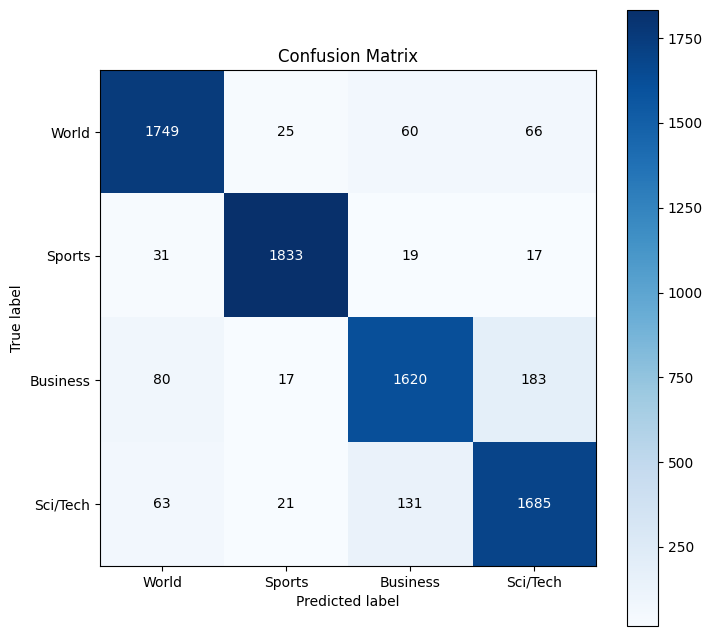

In [45]:
# Call the plot_confusion_matrix function to evaluate the model's performance on the test set
plot_confusion_matrix(rnn_model, test_loader)  # Pass the trained model and the test DataLoader

**Insights**

- **World News**: The model appears to perform well in classifying "World" news, as the diagonal element for this class is relatively high.
- **Sports News**: The model also performs well in classifying "Sports" news.
- **Business and Sci/Tech News**: The model might have more difficulty distinguishing between "Business" and "Sci/Tech" news, as there might be some overlap in the language used in these categories. This is indicated by the off-diagonal elements between these two classes.

## Conclusion

In this activity, we applied Recurrent Neural Networks (RNNs) to classify text from the AG_NEWS dataset. RNNs are effective for sequential data, capturing temporal dependencies in text. The model achieved solid performance with validation accuracies above 90%. However, there are opportunities for improvement. Switching to more advanced architectures like LSTM or GRU could help capture longer-term dependencies. Using pre-trained word embeddings like GloVe or Word2Vec could enhance the model's understanding of word semantics. Hyperparameter tuning, such as adjusting learning rate, batch size, and dropout rate, could also improve accuracy. Additionally, after some research we found that incorporating bidirectional RNNs or attention mechanisms might further boost performance by better handling context in text. These strategies can lead .to more accurate and robust models for text classification tasks like AG_NEW